<a href="https://colab.research.google.com/github/Hou-Y/MML_NTNU/blob/main/receivals_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_pinball_loss, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Config

In [ ]:
plt.style.use('seaborn-v0_8')
RANDOM_STATE = 42
PINBALL_ALPHA = 0.2  # 20th quantile = conservative forecast
LOG_TARGET = True    # log transform to stabilize variance

# Load Data

In [ ]:
# Load the CSV files
receivals = pd.read_csv("receivals.csv")
purchase_orders = pd.read_csv("purchase_orders.csv")

# Print all columns of each DataFrame
print("Receivals columns:")
print(receivals.columns.tolist())

print("\nPurchase Orders columns:")
print(purchase_orders.columns.tolist())

Receivals columns:
['rm_id', 'product_id', 'purchase_order_id', 'purchase_order_item_no', 'receival_item_no', 'batch_id', 'date_arrival', 'receival_status', 'net_weight', 'supplier_id']

Purchase Orders columns:
['purchase_order_id', 'purchase_order_item_no', 'quantity', 'delivery_date', 'product_id', 'product_version', 'created_date_time', 'modified_date_time', 'unit_id', 'unit', 'status_id', 'status']


# Preprocess Receivals

In [ ]:
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
receivals['date'] = pd.to_datetime(receivals['date_arrival'].dt.date)

# Daily net weight per RM
daily_receivals = receivals.groupby(['date', 'rm_id'])['net_weight'].sum().reset_index()

# Full date x rm_id grid
min_date, max_date = daily_receivals['date'].min(), daily_receivals['date'].max()
full_dates = pd.date_range(start=min_date, end=max_date, freq='D')
rm_ids = daily_receivals['rm_id'].unique()
master_index = pd.MultiIndex.from_product([full_dates, rm_ids], names=['date', 'rm_id'])
daily_data = daily_receivals.set_index(['date', 'rm_id']).reindex(master_index, fill_value=0).reset_index()


# EDA

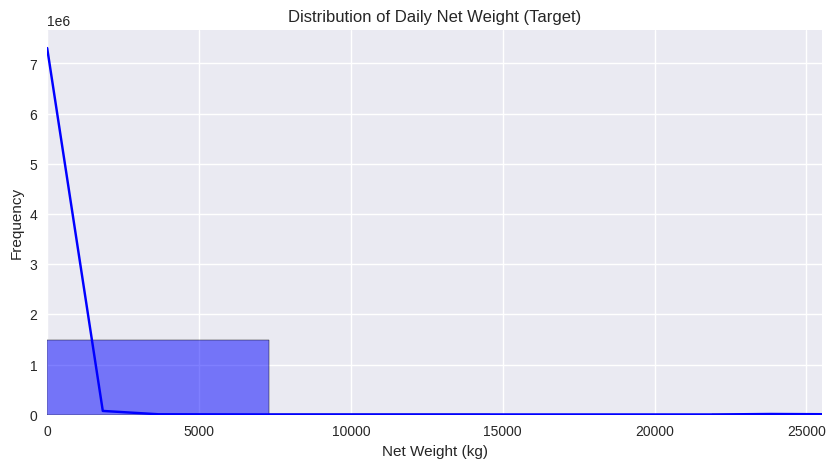

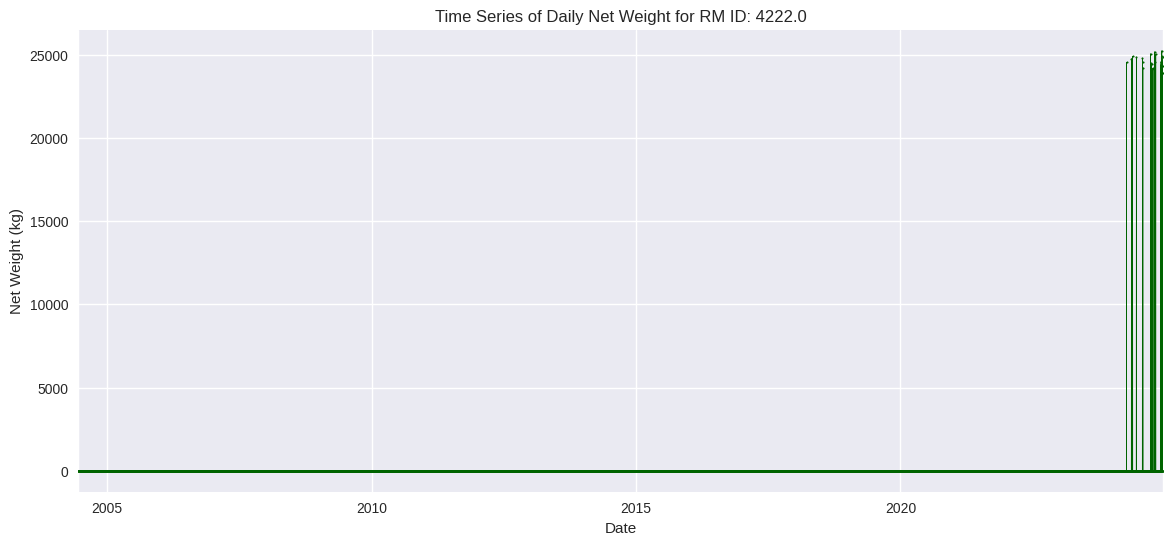

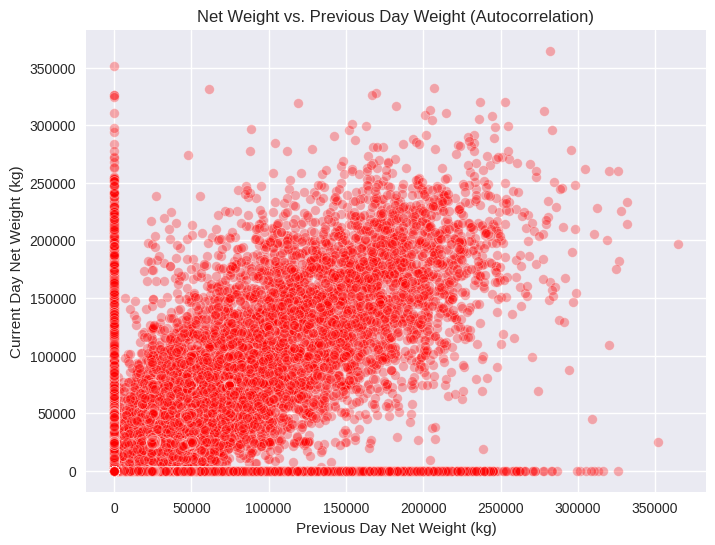

EDA visualizations complete.


In [ ]:
# --- 1. Check if the data is intuitive: Distribution of the Target ---
plt.figure(figsize=(10, 5))
sns.histplot(daily_data['net_weight'], bins=50, kde=True, color='blue')
plt.title('Distribution of Daily Net Weight (Target)')
plt.xlabel('Net Weight (kg)')
plt.ylabel('Frequency')
plt.xlim(0, daily_data['net_weight'].quantile(0.99))
plt.show()

# --- 2. Explore individual features: Time Series Plot ---

sample_rm_id = daily_data['rm_id'].sample(1, random_state=RANDOM_STATE).iloc[0]

plt.figure(figsize=(14, 6))
daily_data[daily_data['rm_id'] == sample_rm_id].set_index('date')['net_weight'].plot(
    marker='.', linestyle='-', linewidth=0.5, markersize=3, color='darkgreen'
)
plt.title(f'Time Series of Daily Net Weight for RM ID: {sample_rm_id}')
plt.xlabel('Date')
plt.ylabel('Net Weight (kg)')
plt.grid(True)
plt.show()


# --- 3. Explore pairs of features: Correlation with Target ---
temp_df = daily_data.copy()
temp_df['prev_day_weight'] = temp_df.groupby('rm_id')['net_weight'].shift(1)
temp_df.dropna(subset=['prev_day_weight'], inplace=True)


plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=temp_df['prev_day_weight'],
    y=temp_df['net_weight'],
    alpha=0.3,
    color='red'
)
plt.title('Net Weight vs. Previous Day Weight (Autocorrelation)')
plt.xlabel('Previous Day Net Weight (kg)')
plt.ylabel('Current Day Net Weight (kg)')
plt.grid(True)
plt.show()

print("EDA visualizations complete.")


# Preprocess Purchase Orders (Leakage-Free)

In [ ]:
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)
purchase_orders.rename(columns={'product_id': 'rm_id'}, inplace=True)

# Daily ordered quantity per rm_id
daily_orders = (
    purchase_orders.groupby(['delivery_date', 'rm_id'])['quantity']
    .sum()
    .reset_index()
    .rename(columns={'delivery_date': 'date', 'quantity': 'ordered_quantity_today'})
)

# Merge into daily_data
daily_data = pd.merge(daily_data, daily_orders, on=['date', 'rm_id'], how='left')

# Fill NaNs (no orders that day)
daily_data['ordered_quantity_today'] = daily_data['ordered_quantity_today'].fillna(0)

# Build safe, leakage-free cumulative feature
print("🔄 Building leakage-free cumulative_orders feature...")
daily_data['cumulative_orders'] = (
    daily_data.sort_values(by=['rm_id', 'date'])
    .groupby('rm_id')['ordered_quantity_today']
    .cumsum()
)

🔄 Building leakage-free cumulative_orders feature...


# Feature Engineering

In [ ]:
# Time-based features
daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
daily_data['day_of_week'] = daily_data['date'].dt.dayofweek

# Lag features on net weight
daily_data['prev_day_weight'] = daily_data.groupby('rm_id')['net_weight'].shift(1)
daily_data['prev_3day_avg'] = (
    daily_data.groupby('rm_id')['net_weight']
    .shift(1)
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)
daily_data['rolling_7d_std'] = (
    daily_data.groupby('rm_id')['net_weight']
    .shift(1)
    .rolling(7)
    .std()
    .reset_index(level=0, drop=True)
)
daily_data['diff_weight'] = daily_data.groupby('rm_id')['net_weight'].diff()

# ✅ Lag feature on orders (correct column name!)
daily_data['lag_order_1'] = daily_data.groupby('rm_id')['ordered_quantity_today'].shift(1)

# Encoding
le = LabelEncoder()
daily_data['rm_id_encoded'] = le.fit_transform(daily_data['rm_id'])

# Drop NA from lag features (remove first few rows with missing lags)
daily_data.dropna(inplace=True)

# Features & Target

In [ ]:
FEATURES = [
    'day_of_year', 'day_of_week',
    'prev_day_weight', 'prev_3day_avg', 'rolling_7d_std', 'diff_weight',
    'lag_order_1', 'ordered_quantity_today', 'cumulative_orders',
    'rm_id_encoded'
]

TARGET = 'net_weight'

if LOG_TARGET:
    daily_data['log_target'] = np.log1p(daily_data[TARGET])
    y = daily_data['log_target']
else:
    y = daily_data[TARGET]

X = daily_data[FEATURES]

# Train/Test Split (time-aware)

In [ ]:
split_date = daily_data['date'].max() - pd.Timedelta(days=90)
X_train = X[daily_data['date'] < split_date]
X_test = X[daily_data['date'] >= split_date]
y_train = y[daily_data['date'] < split_date]
y_test = y[daily_data['date'] >= split_date]
df_test = daily_data[daily_data['date'] >= split_date].copy()


# Model: Quantile Regressor (20th percentile)

In [ ]:
model = XGBRegressor(
    objective='reg:quantileerror',  # quantile regression
    quantile_alpha=PINBALL_ALPHA,
    n_estimators=800,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    tree_method='hist'
)

# Feature Selection via Feature Importance


Fitting baseline model for feature importance...


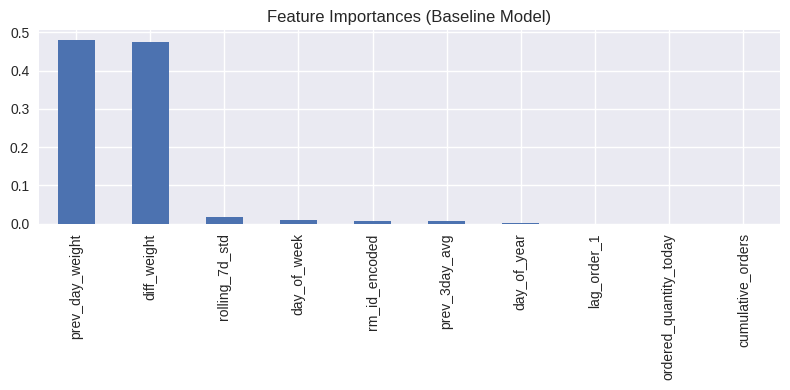

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: ['prev_day_weight' 'diff_weight']
Using top 6 features: ['prev_day_weight', 'diff_weight', 'rolling_7d_std', 'day_of_week', 'rm_id_encoded', 'prev_3day_avg']
Selected features: ['prev_day_weight', 'diff_weight', 'rolling_7d_std', 'day_of_week', 'rm_id_encoded', 'prev_3day_avg']

Fitting GradientBoostingRegressor for PDP visualization...


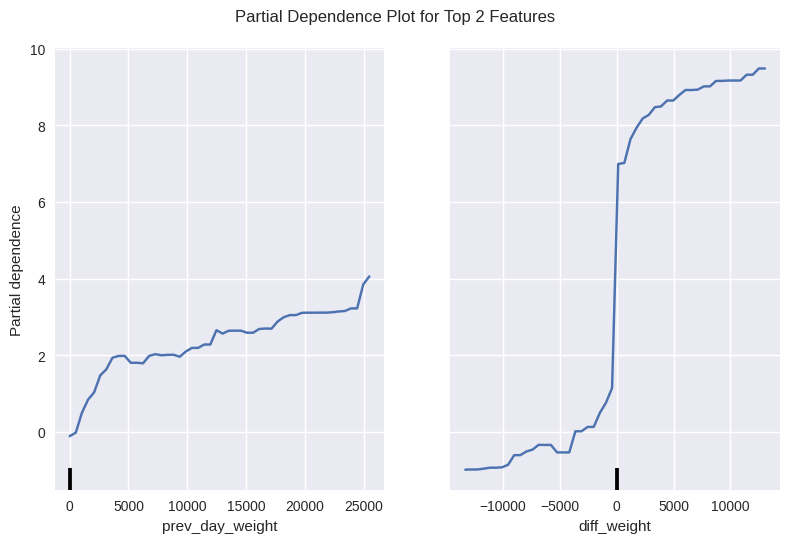

In [ ]:
print("\nFitting baseline model for feature importance...")
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)

plt.figure(figsize=(8,4))
importances.plot(kind='bar')
plt.title("Feature Importances (Baseline Model)")
plt.tight_layout()
plt.show()

# Select only features above mean importance
selector = SelectFromModel(model, threshold="mean", prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = np.array(FEATURES)[selector.get_support()]
print(f"Selected features: {selected_features}")

# Automatically take the top 6 features
top_n = 6
top_features = importances.index[:top_n]
print(f"Using top {top_n} features: {list(top_features)}")

X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]
selected_features = list(top_features)
print(f"Selected features: {selected_features}")

# Fit a basic model for PDP visualization
print("\nFitting GradientBoostingRegressor for PDP visualization...")
simple_model = GradientBoostingRegressor(random_state=RANDOM_STATE)
simple_model.fit(X_train_selected, y_train)

# Try PDP for top 2 features, force percentile spread
PartialDependenceDisplay.from_estimator(
    estimator=simple_model,
    X=X_train_selected,
    features=[0, 1],
    feature_names=selected_features,
    grid_resolution=50,
    percentiles=(0.01, 0.99)  # 👈 force range
)
plt.suptitle("Partial Dependence Plot for Top 2 Features")
plt.tight_layout()
plt.show()

# TimeSeries Cross-Validation

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
cv_losses = []

print("Starting Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_selected)):
    X_tr, X_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    if LOG_TARGET:
        y_val_pred_exp = np.expm1(y_val_pred)
        y_val_exp = np.expm1(y_val)
    else:
        y_val_pred_exp = y_val_pred
        y_val_exp = y_val

    df_val = daily_data.iloc[val_idx].copy()
    df_val['predicted_net_weight'] = y_val_pred_exp
    y_val_cum_actual = df_val.groupby('rm_id')['net_weight'].cumsum()
    y_val_cum_pred = df_val.groupby('rm_id')['predicted_net_weight'].cumsum()

    loss = mean_pinball_loss(y_val_cum_actual, y_val_cum_pred, alpha=PINBALL_ALPHA)
    cv_losses.append(loss)
    print(f"Fold {fold+1} - P{int(PINBALL_ALPHA*100)} Pinball Loss: {loss:.2f}")

print(f"\n✅ Average CV P{int(PINBALL_ALPHA*100)} Pinball Loss: {np.mean(cv_losses):.2f}")


Starting Cross-Validation...
Fold 1 - P20 Pinball Loss: 18911.64
Fold 2 - P20 Pinball Loss: 33038.56
Fold 3 - P20 Pinball Loss: 43888.89
Fold 4 - P20 Pinball Loss: 39354.18
Fold 5 - P20 Pinball Loss: 28971.65

✅ Average CV P20 Pinball Loss: 32832.99


# Train Final Model

In [ ]:
print("\nTraining final model on full training set...")
model.fit(X_train_selected, y_train)



Training final model on full training set...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

# Final Evaluation

In [ ]:
y_pred_net = model.predict(X_test_selected)

if LOG_TARGET:
    y_pred_net = np.expm1(y_pred_net)
    y_test_net = np.expm1(y_test)
else:
    y_test_net = y_test

df_test['predicted_net_weight'] = y_pred_net
df_test['actual_net_weight'] = y_test_net

# Cumulative sums
df_test['cumulative_actual'] = df_test.groupby('rm_id')['actual_net_weight'].cumsum()
df_test['cumulative_predicted'] = df_test.groupby('rm_id')['predicted_net_weight'].cumsum()

# Metrics
pinball_loss = mean_pinball_loss(df_test['cumulative_actual'], df_test['cumulative_predicted'], alpha=PINBALL_ALPHA)
r2 = r2_score(df_test['cumulative_actual'], df_test['cumulative_predicted'])

print("\n📊 Final Evaluation (Cumulative):")
print(f"P{int(PINBALL_ALPHA*100)} Pinball Loss: {pinball_loss:.2f}")
print(f"R² Score (cumulative): {r2:.4f}")



📊 Final Evaluation (Cumulative):
P20 Pinball Loss: 1881.95
R² Score (cumulative): 0.9734


# Plot Predicted vs Actual Cumulative

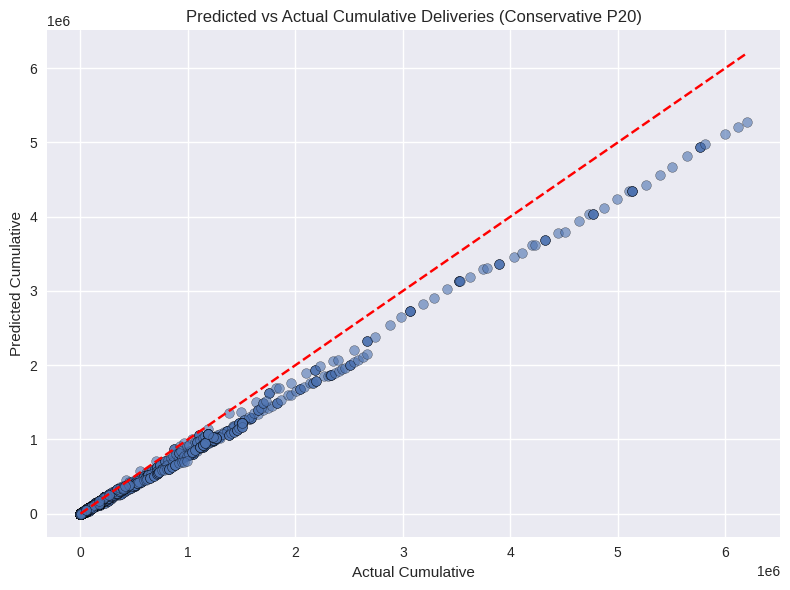

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_test['cumulative_actual'], df_test['cumulative_predicted'], alpha=0.6, edgecolors='k')
plt.plot([df_test['cumulative_actual'].min(), df_test['cumulative_actual'].max()],
         [df_test['cumulative_actual'].min(), df_test['cumulative_actual'].max()], 'r--')
plt.title('Predicted vs Actual Cumulative Deliveries (Conservative P20)')
plt.xlabel('Actual Cumulative')
plt.ylabel('Predicted Cumulative')
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Submission Files (exactly 30,450 rows)


In [ ]:
import itertools

# 1️⃣ Get all unique rm_ids
unique_rm_ids = sorted(daily_data['rm_id'].unique())

# 2️⃣ Define forecast period (next 30 days after your last date)
forecast_start = daily_data['date'].max() + pd.Timedelta(days=1)
forecast_horizon_days = int(np.ceil(30450 / len(unique_rm_ids)))
forecast_end = forecast_start + pd.Timedelta(days=forecast_horizon_days - 1)
full_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='D')

# 3️⃣ Create full grid (rm_id × date)
submission_grid = pd.DataFrame(
    list(itertools.product(unique_rm_ids, full_dates)),
    columns=['rm_id', 'date']
)

# 4️⃣ Prepare latest known data per rm_id for feature generation
latest_data = daily_data.groupby('rm_id').tail(1).set_index('rm_id')

def make_forecast_features(rm_id, date):
    if rm_id in latest_data.index:
        row = latest_data.loc[rm_id].copy()
        row['date'] = date
        row['day_of_year'] = date.timetuple().tm_yday
        row['day_of_week'] = date.weekday()
        return row[selected_features].values
    else:
        return np.zeros(len(selected_features))

# 5️⃣ Generate features for each rm_id × date
X_forecast = np.vstack([
    make_forecast_features(rm, d)
    for rm, d in zip(submission_grid['rm_id'], submission_grid['date'])
])

# 6️⃣ Predict
y_forecast = model.predict(X_forecast)
if LOG_TARGET:
    y_forecast = np.expm1(y_forecast)

submission_grid['predicted_weight'] = np.clip(y_forecast, 0, None)
submission_grid['cumulative_predicted'] = submission_grid.groupby('rm_id')['predicted_weight'].cumsum()
submission_grid['ID'] = np.arange(1, len(submission_grid) + 1)

# 7️⃣ Build submission files
prediction_mapping = pd.DataFrame({
    'ID': submission_grid['ID'],
    'rm_id': submission_grid['rm_id'],
    'forecast_start_date': submission_grid['date'],
    'forecast_end_date': submission_grid['date']
})

sample_submission = pd.DataFrame({
    'ID': submission_grid['ID'],
    'predicted_weight': submission_grid['cumulative_predicted']
})

# 8️⃣ Enforce exactly 30,450 rows (truncate or extend if needed)
target_rows = 30450
if len(sample_submission) > target_rows:
    sample_submission = sample_submission.head(target_rows)
    prediction_mapping = prediction_mapping.head(target_rows)
elif len(sample_submission) < target_rows:
    missing_rows = target_rows - len(sample_submission)
    print(f"⚠️ Found {len(sample_submission)} rows, extending forecast with {missing_rows} new rows...")

    # Calcoliamo quante nuove date servono
    extra_days_needed = int(np.ceil(missing_rows / len(unique_rm_ids)))
    extra_dates = pd.date_range(
        start=forecast_end + pd.Timedelta(days=1),
        periods=extra_days_needed,
        freq='D'
    )

    extra_rows = pd.DataFrame(
        list(itertools.product(unique_rm_ids, extra_dates)),
        columns=['rm_id', 'date']
    )

    extra_features = np.vstack([
        make_forecast_features(rm, d)
        for rm, d in zip(extra_rows['rm_id'], extra_rows['date'])
    ])

    y_extra = model.predict(extra_features)
    if LOG_TARGET:
        y_extra = np.expm1(y_extra)

    # ✅ usa np.clip al posto di .clip(lower=0)
    extra_rows['predicted_weight'] = np.clip(y_extra, 0, None)
    extra_rows['cumulative_predicted'] = extra_rows.groupby('rm_id')['predicted_weight'].cumsum()
    extra_rows['ID'] = np.arange(len(submission_grid) + 1, len(submission_grid) + 1 + len(extra_rows))

    # Aggiungiamo e tagliamo a 30 450
    submission_grid = pd.concat([submission_grid, extra_rows], ignore_index=True)
    sample_submission = pd.DataFrame({
        'ID': submission_grid['ID'],
        'predicted_weight': submission_grid['cumulative_predicted']
    }).head(target_rows)
    prediction_mapping = pd.DataFrame({
        'ID': submission_grid['ID'],
        'rm_id': submission_grid['rm_id'],
        'forecast_start_date': submission_grid['date'],
        'forecast_end_date': submission_grid['date']
    }).head(target_rows)


# 9️⃣ Save final outputs
prediction_mapping.to_csv("prediction_mapping.csv", index=False)
sample_submission.to_csv("sample_submission.csv", index=False)

print(f"✅ prediction_mapping.csv saved with {len(prediction_mapping)} rows.")
print(f"✅ sample_submission.csv saved with {len(sample_submission)} rows.")
print("✅ Row count matches expected submission length (30450).")

print(sample_submission.describe())
print((sample_submission['predicted_weight'] < 0).sum())

✅ prediction_mapping.csv saved with 30450 rows.
✅ sample_submission.csv saved with 30450 rows.
✅ Row count matches expected submission length (30450).
                 ID  predicted_weight
count  30450.000000      3.045000e+04
mean   15225.500000      5.845433e+04
std     8790.302185      4.188789e+05
min        1.000000      0.000000e+00
25%     7613.250000      0.000000e+00
50%    15225.500000      0.000000e+00
75%    22837.750000      0.000000e+00
max    30450.000000      6.954009e+06
0


# MODEL 2: LightGBM Quantile Regressor Definition

In [ ]:
lgbm_model = LGBMRegressor(
    objective='quantile',  # quantile regression
    alpha=PINBALL_ALPHA,
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=8,
    num_leaves=64,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=RANDOM_STATE
)

SyntaxError: invalid non-printable character U+00A0 (ipython-input-1127426508.py, line 2)

# Train Final LightGBM Model

In [ ]:
print("\nTraining final LightGBM model on full training set...")
lgbm_model.fit(X_train_selected, y_train)

# Predict and Evaluate LightGBM

In [ ]:
y_pred_lgbm = lgbm_model.predict(X_test_selected)

if LOG_TARGET:
    y_pred_lgbm = np.expm1(y_pred_lgbm)

df_test.rename(columns={'cumulative_predicted': 'cumulative_predicted_xgb'}, inplace=True)

# Store LightGBM net predictions
df_test['predicted_lgbm'] = y_pred_lgbm

# Calculate LightGBM Cumulative sums
df_test['cumulative_predicted_lgbm'] = df_test.groupby('rm_id')['predicted_lgbm'].cumsum()

# --- Metrics Calculation ---
# XGBoost Metrics (recalculated using renamed column)
metrics = {}
metrics['xgb_loss'] = mean_pinball_loss(df_test['cumulative_actual'], df_test['cumulative_predicted_xgb'], alpha=PINBALL_ALPHA)
metrics['xgb_r2'] = r2_score(df_test['cumulative_actual'], df_test['cumulative_predicted_xgb'])
metrics['xgb_coverage'] = (df_test['cumulative_predicted_xgb'] < df_test['cumulative_actual']).mean()

# LightGBM Metrics
metrics['lgbm_loss'] = mean_pinball_loss(df_test['cumulative_actual'], df_test['cumulative_predicted_lgbm'], alpha=PINBALL_ALPHA)
metrics['lgbm_r2'] = r2_score(df_test['cumulative_actual'], df_test['cumulative_predicted_lgbm'])
metrics['lgbm_coverage'] = (df_test['cumulative_predicted_lgbm'] < df_test['cumulative_actual']).mean()

print("📊 FINAL CUMULATIVE METRICS for LightGBM (Conservative P20)")
print(f"Target Quantile (Alpha): {PINBALL_ALPHA}")
print("=============================================================")
print(f"LightGBM P{int(PINBALL_ALPHA*100)} Pinball Loss: {metrics['lgbm_loss']:.4f}")
print(f"LightGBM R² Score: {metrics['lgbm_r2']:.4f}")



# Plot Predicted vs Actual Cumulative

In [ ]:
plt.figure(figsize=(10, 8))

# LightGBM Predictions (The new model)
plt.scatter(df_test['cumulative_actual'], df_test['cumulative_predicted_lgbm'],
            alpha=0.6, edgecolors='k', color='tab:orange', label='LightGBM P20 Prediction')

# Ideal Line
min_val = df_test['cumulative_actual'].min()
max_val = df_test['cumulative_actual'].max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction (y=x)')

plt.title('Predicted vs Actual Cumulative Deliveries (LightGBM P20)')
plt.xlabel('Actual Cumulative Net Weight')
plt.ylabel('Predicted Cumulative Net Weight (P20)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
